In [1]:
from dataretrieval import nwis
import geopandas as gpd
from pathlib import Path

In [2]:
fn = Path('../../data/basin_shapefile/gunnison_boundary/gunnison_boundary.shp')
gdf = gpd.read_file(fn)

gdf.bounds.values[0]

array([-107.6875,   37.875 , -106.25  ,   39.0625])

In [3]:
startDt = '2010-01-01'
endDt = '2023-02-01'

# siteListPhos = nwis.what_sites(stateCd="CO", parameterCd="00665")
siteListPhos = nwis.what_sites(bBox=list(gdf.bounds.values[0].round(4)), startDt=startDt, endDt=endDt, parameterCd='00060', )

In [4]:
filtered_sites = siteListPhos[0]
filtered_sites.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd
0,USGS,09107000,"TAYLOR RIVER AT TAYLOR PARK, CO.",ST,38.860271,-106.566697,S,NAD83,9340.00,10.0,NGVD29,14020001
1,USGS,09107500,"TEXAS CREEK AT TAYLOR PARK, CO",ST,38.846944,-106.554639,5,NAD83,9380.00,10.0,NGVD29,14020001
2,USGS,09108250,"WILLOW CREEK ABOVE TAYLOR PARK RESERVOIR, CO.",ST,38.817936,-106.560750,F,NAD83,9368.00,1.6,NAVD88,14020001
3,USGS,09109000,"TAYLOR RIVER BELOW TAYLOR PARK RESERVOIR, CO.",ST,38.818327,-106.609198,F,NAD83,9169.67,15.0,NGVD29,14020001
4,USGS,09110000,"TAYLOR RIVER AT ALMONT, CO.",ST,38.664437,-106.845317,F,NAD83,8010.76,15.0,NGVD29,14020001


In [17]:
filtered_sites = gpd.GeoDataFrame(filtered_sites, geometry=gpd.points_from_xy(filtered_sites['dec_long_va'], filtered_sites['dec_lat_va']), crs='epsg:4326')
sites_within_basin = filtered_sites[filtered_sites.within(gdf.geometry[0])]

<GeoAxesSubplot:>

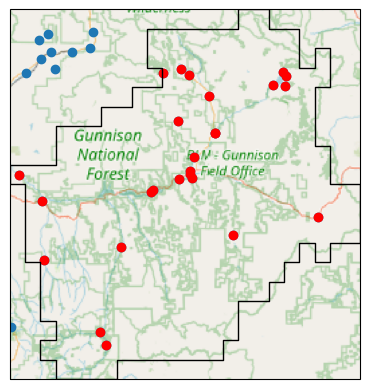

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import warnings
warnings.filterwarnings('ignore')

f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

request = cimgt.OSM()
extent = gdf.bounds[['minx', 'maxx', 'miny', 'maxy']].values[0]
ax.set_extent(extent)
ax.add_image(request, 8)

filtered_sites.plot(ax=ax)
sites_within_basin.plot(ax=ax, color='red')
gdf.plot(ax=ax, fc='none', label='Gunnison basin boundary')